In [1]:
#Antes de tudo:
#!pip install git+https://github.com/quantopian/pyfolio
#!pip install pyfolio
#!pip install yfinance
#!pip install pulp
#!pip install pandas datareader
#!pip install workadays
#!pip install workalendar

# Importando bibliotecas
import pandas as pd
import numpy as np
import pyfolio as pf  
from pandas_datareader import data as web
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
from workadays import workdays as wd

# Plots
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina'   # Plots de alta resolução

# Filtrar warnings
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'pandas'

# Extração dos dados financeiros #

In [ ]:

# Criando função para importar os dados desejados das ações

def cotacoes_acoes(tickers, dataInicio):
    """Baixa todos os dados de fechamento de mercado passando os tickers em
    lista e a data de inicio no formato mm/dd/aaaa
    Como padrão: Ínidce Bovespa e 01/01/2017
    Consultar o nome dos tickers no site do Yahoo"""
    
    #Garantindo todos os tickers em maiusculo
    tickers = [x.upper() for x in tickers]
    
    prices = pd.DataFrame()    
    
    for i in tickers:
        if '^BVSP' in i:
            prices[i] = web.get_data_yahoo(i,dataInicio)['Adj Close']
        elif 'USDBRL=X' in i:
            prices[i] = web.get_data_yahoo(i,dataInicio)['Adj Close']
        elif '.SA' in i:
            prices[i] = web.get_data_yahoo(i,dataInicio)['Adj Close']
        else:
            i = i+'.SA'
            prices[i] = web.get_data_yahoo(i,dataInicio)['Adj Close']
    
    #arredondar os valores para 2 casas decimais
    prices = np.round(prices, decimals=2)
    
    if "^BVSP" in tickers:
        prices['^BVSP'] = prices['^BVSP']/1000
    
    prices.rename(columns = {'USDBRL=X':'Dolar', '^BVSP':'Bovespa'}, inplace = True)

    prices = prices.dropna()
    
    return prices

def retornos(prices):
  #Calculando retorno e retorno acumulado
  retorno = prices.pct_change().mul(100)
  retorno_acumulado = (1 + retorno.div(100)).cumprod()
  retorno_acumulado.iloc[0] = 1
  retorno = np.round(retorno, decimals=4)
  retorno_acumulado = np.round(retorno_acumulado, decimals=4)
  return retorno, retorno_acumulado

def carteiras(retorno_acumulado, valor: float):
  #Simulação carteira
  cols = cotacao.shape[1] # numero colunas do dataframe
  carteira = valor * retorno_acumulado.iloc[:, :cols]
  carteira['Bovespa'] = valor * (cols-2) * retorno_acumulado['Bovespa']
  carteira['Dolar'] = valor * (cols-2) * retorno_acumulado['Dolar']
  carteira['Saldo_Carteira'] = carteira.sum(axis=1) - carteira['Bovespa'] - carteira['Dolar']
  carteira['Retorno_Carteira'] = carteira['Saldo_Carteira'].pct_change()
  return carteira

def desvios(cotacao, start, end) -> list:
  nomes = cotacao.columns

  # Converte em data 1º vencimento opção
  d1 = datetime.strptime(start, '%d/%m/%Y').date()

  # Converte em data 2º vencimento opção
  d2 = datetime.strptime(end, '%d/%m/%Y').date()

  # Obtém 1 dia útil 1 ano antes do valor de início
  d0 = d1 - timedelta(days=365)
  offset = pd.tseries.offsets.BusinessDay(n=1)
  res = (d0 - offset).date()

  dados = pd.DataFrame(index=['2DvP', '1,5Dvp', '1Dvp', '0,5Dvp', f'Preço Calculado na Data {d2}','-0,5Dvp', '-1Dvp', '-1,5Dvp', '-2Dvp' ])
  ind = pd.DataFrame(index=['Volatilidade Histórica', 'Volatilidade no Período', 'Retorno Diário', 
                            'Dias úteis Data Inicial a Data final', f'Preço Cotação na Data {d1}', f'Preço Calculado na Data {d2}', 'Data Início Leitura'])


  for nome in nomes:
    # Dias uteis entre as datas de vencimento das opções
    du = wd.networkdays(d1, d2, country='BR')

    # Volatilidade Histórica Anualizada
    sth = cotacao[f'{nome}'][res:d1].pct_change().mul(100).std()*(252**0.5)

    # Converte volatilidade histórica em dias uteis úteis entre vencimento opções
    st = sth/(du**0.5)
    
    # Calcula retorno acumulado no último ano:    
    
    retorn = cotacao[f'{nome}'][res:d1].pct_change().mul(100)
    retorn_acumulado = (1 + retorn.div(100)).cumprod()
    retorn_acumulado.iloc[0] = 1
    retorn = np.round(retorn, decimals=4)
    retorn_acumulado = np.round(retorn_acumulado, decimals=4)
    ret = retorn_acumulado[-1]**(1/retorn.count())

    # Preço na data d1 (1º vencimento opção)
    p1 = cotacao[f'{nome}'][f'{d1}']
    
    # calcula o preço projetado na data final definida (2º vencimento opção)
    pf = cotacao[f'{nome}'][f'{d1}']*((ret)**du)
    dados[nome] = [pf*(2*st/100+ret), pf*(1.5*st/100+ret), pf*(st/100+ret),pf*(0.5*st/100+ret), pf,pf*(-0.5*st/100+ret),pf*(-st/100+ret),pf*(-1.5*st/100+ret),pf*(-2*st/100+ret)]
    ind[nome] = [sth, st, ret, du, p1, pf, res]
  
  return dados, ind

In [ ]:
datas = ['21/01/2022','18/02/2022','18/03/2022','15/04/2022','20/05/2022','17/06/2022','15/07/2022','19/08/2022','16/09/2022','21/10/2022','18/11/2022','16/12/2022']
data = datetime.strptime('21/01/2022', '%d/%m/%Y').date()
data

datetime.date(2022, 1, 21)

In [ ]:
# Período

start= '18/06/2017'
end = '17/07/2022'

# Ações
tickers1 = ['BBAS3', 'VALE3', 'PETR4', 'MGLU3', 'GOAU4', 'CPFE3', 'ABEV3', 'KLBN3']
tickers2 = ['USDBRL=X', '^BVSP'] 
tickers = tickers1 + tickers2 # deixando pronto para streamlit

# Valor investido:
valor = 5000

# Carteiras
cotacao = cotacoes_acoes(tickers, start)
retorno = retornos(cotacao)[0]
retorno_acumulado = retornos(cotacao)[1]
carteira = carteiras(retorno_acumulado, valor)
analise = desvios(cotacao, '20/06/2022','15/07/2022')


In [ ]:
# Tabela Desvio Padrão
analise[0]

,BBAS3.SA,VALE3.SA,PETR4.SA,MGLU3.SA,GOAU4.SA,CPFE3.SA,ABEV3.SA,KLBN3.SA,Dolar,Bovespa
2DvP,39.587830,87.586227,33.367889,2.865866,11.513561,39.250795,14.330075,4.845805,5.657567,107.138452
"1,5Dvp",38.345858,84.187085,32.139152,2.681418,11.068761,38.090494,13.915156,4.674224,5.544861,104.735514
1Dvp,37.103887,80.787942,30.910414,2.496970,10.623962,36.930193,13.500237,4.502643,5.432156,102.332577
"0,5Dvp",35.861915,77.388800,29.681677,2.312522,10.179162,35.769892,13.085318,4.331062,5.319450,99.929639
Preço Calculado na Data 2022-07-15,34.608409,74.064452,28.410702,2.148663,9.740112,34.557884,12.689114,4.164938,5.205906,97.641719
"-0,5Dvp",33.377971,70.590515,27.224202,1.943626,9.289563,33.449289,12.255480,3.987899,5.094039,95.123764
-1Dvp,32.135999,67.191373,25.995465,1.759178,8.844764,32.288988,11.840561,3.816318,4.981333,92.720826
"-1,5Dvp",30.894027,63.792231,24.766727,1.574729,8.399964,31.128687,11.425642,3.644737,4.868627,90.317889
-2Dvp,29.652055,60.393088,23.537990,1.390281,7.955164,29.968385,11.010723,3.473156,4.755921,87.914951


In [ ]:
# Tabela Parâmetros
analise[1]

,BBAS3.SA,VALE3.SA,PETR4.SA,MGLU3.SA,GOAU4.SA,CPFE3.SA,ABEV3.SA,KLBN3.SA,Dolar,Bovespa
Volatilidade Histórica,31.285054,40.009796,37.703693,74.836371,39.811375,29.270519,28.506172,35.914342,18.873675,21.454276
Volatilidade no Período,7.177284,9.178877,8.64982,17.168641,9.133356,6.715118,6.539764,8.239315,4.329918,4.921949
Retorno Diário,1.000333,0.99899,1.001487,0.990418,0.99941,1.001496,0.998525,0.99869,1.000161,0.998822
Dias úteis Data Inicial a Data final,19,19,19,19,19,19,19,19,19,19
Preço Cotação na Data 2022-06-20,34.39,75.5,27.62,2.58,9.85,33.59,13.05,4.27,5.19,99.853
Preço Calculado na Data 2022-07-15,34.608409,74.064452,28.410702,2.148663,9.740112,34.557884,12.689114,4.164938,5.205906,97.641719
Data Início Leitura,2021-06-18,2021-06-18,2021-06-18,2021-06-18,2021-06-18,2021-06-18,2021-06-18,2021-06-18,2021-06-18,2021-06-18


### Cotação ###

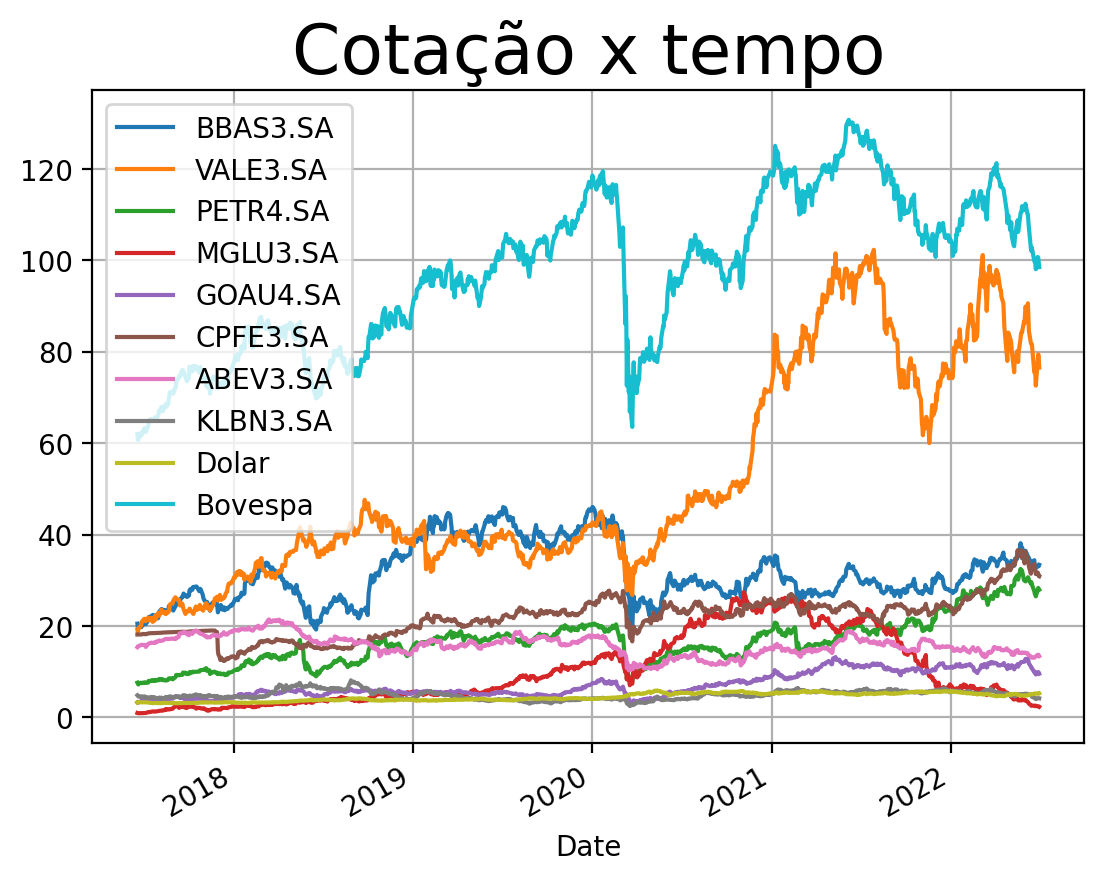

In [ ]:
cotacao.plot()
plt.title("Cotação x tempo", fontsize = 25)
plt.grid()
plt.show()

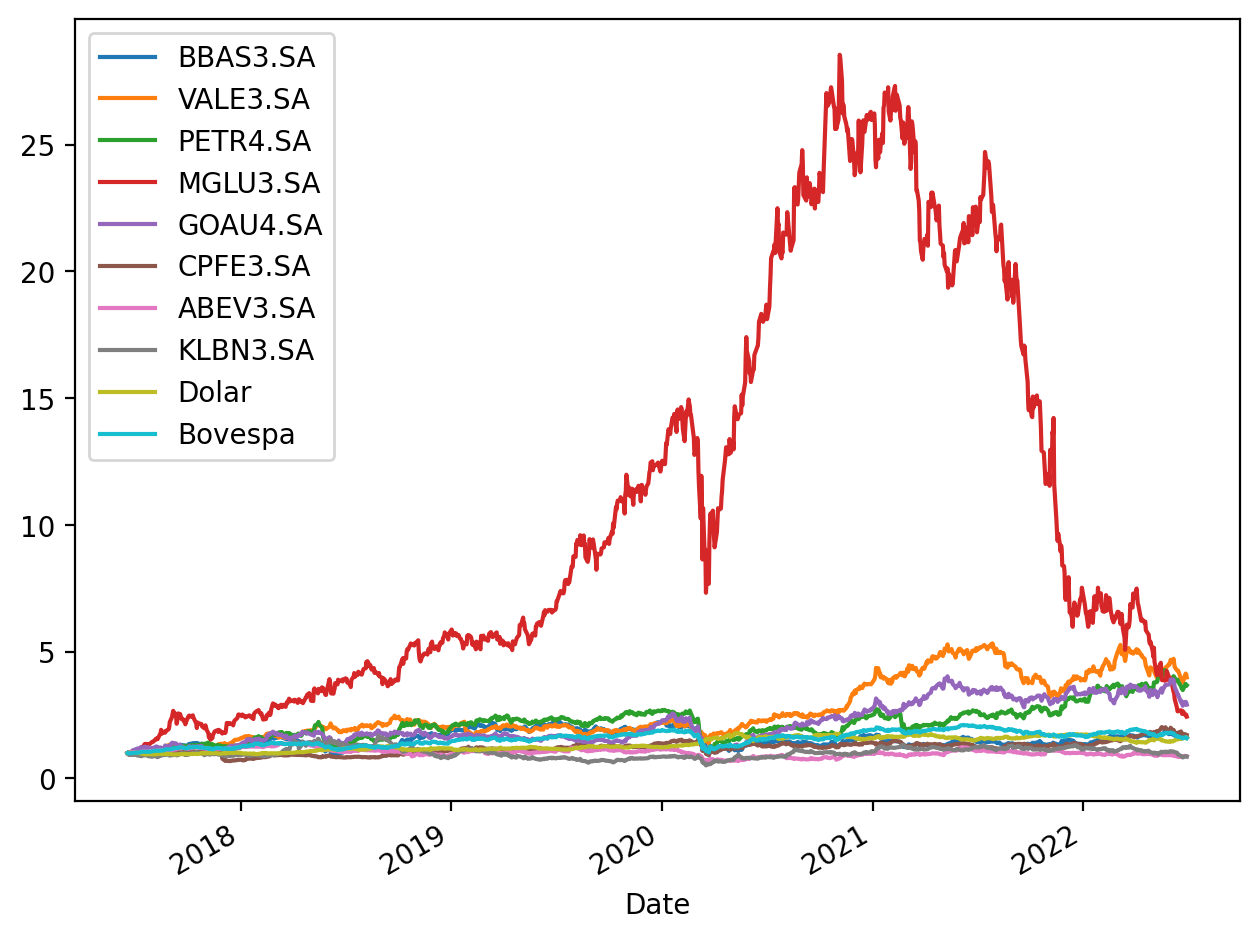

In [ ]:
# Retorno Acumulado
retorno_acumulado.plot()
plt.tight_layout()
plt.show()

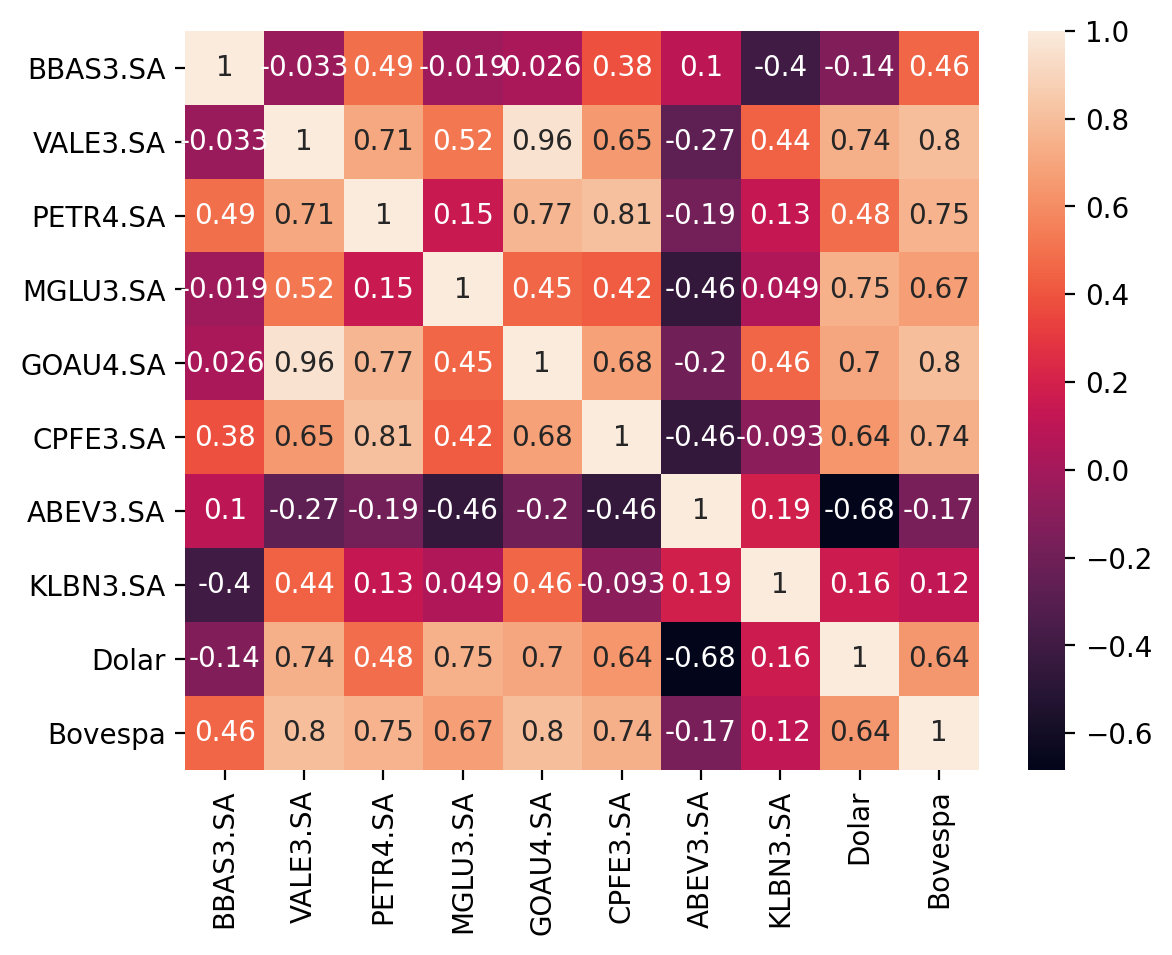

In [ ]:
# Correlação entre ativos
sns.heatmap(cotacao.corr(), annot = True)
plt.show()

In [ ]:
carteira

,BBAS3.SA,VALE3.SA,PETR4.SA,MGLU3.SA,GOAU4.SA,CPFE3.SA,ABEV3.SA,KLBN3.SA,Dolar,Bovespa,Saldo_Carteira,Retorno_Carteira
Date,,,,,,,,,,,,
2017-06-19,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,40000.0,40000.0,40000.0,NaN
2017-06-20,4790.5,4870.0,4829.0,4791.5,4847.5,5000.0,5055.5,4865.5,40608.0,39196.0,39049.5,-0.023763
2017-06-21,4766.0,5015.5,4737.0,4791.5,5000.0,5000.0,5071.5,4731.0,40608.0,39192.0,39112.5,0.001613
2017-06-22,4790.5,5119.5,4901.5,4687.5,5076.0,5000.0,5091.0,4803.5,40732.0,39520.0,39469.5,0.009128
2017-06-26,4971.0,5203.0,4993.5,4896.0,5335.5,5005.5,5156.0,4648.0,40120.0,40112.0,40208.5,0.018723
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-23,7955.5,18896.5,17427.5,13281.0,14329.5,8644.0,4336.5,4141.0,63904.0,63264.0,89011.5,-0.014471
2022-06-27,8072.5,20315.0,18408.0,12656.0,15076.0,8735.0,4463.0,4348.0,63904.0,64996.0,92073.5,0.034400
2022-06-28,8102.0,20679.5,18638.0,12396.0,15106.5,8666.0,4398.0,4379.0,64268.0,64884.0,92365.0,0.003166


In [5]:
datas = ['21/01/2022','18/02/2022','18/03/2022','15/04/2022','20/05/2022','17/06/2022','15/07/2022','19/08/2022','16/09/2022','21/10/2022','18/11/2022','16/12/2022']

d = '20/05/2022'

datas.index(d)

datas[datas.index(d):]

['20/05/2022',
 '17/06/2022',
 '15/07/2022',
 '19/08/2022',
 '16/09/2022',
 '21/10/2022',
 '18/11/2022',
 '16/12/2022']